In [ ]:
import tensorflow as tf
tf.__version__

## 8.1 循环神经网络简介

#### 循环神经网络主要用途是处理和预测序列数据

#### 隐藏层的输入不仅包括输入层的输出，还包括上一时刻隐藏层的输出

#### 循环神经网络前向传播示例：

![2136](../TfInActionImg/2136.PNG)

![2145](../TfInActionImg/2145.PNG)

#### 代码复现图8-5

In [ ]:
import numpy as np

X = [1,2]
state = [0.0, 0.0]
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4]])
w_cell_input = np.asarray([0.5, 0.6])
b_cell = np.asarray([0.1, -0.1])
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

for i in range(len(X)):
    before_activation = np.dot(state, w_cell_state) + X[i] * w_cell_input + b_cell
    state = np.tanh(before_activation)
    final_output = np.dot(state, w_output) + b_output
    print "before activation: ", before_activation
    print "state: ", state
    print "output: ", final_output

#### 和其他神经网络类似，在定义完损失函数之后，套用第 4 章 中介绍的优化框架TensorFlow 就可以自动完成模型训练的过程 。这里唯一需要特别指出的是，理论上循环神经网络可以支持任意长度的序列，然而在实际训练过程中 ，如果序列过长， 一方面会导致优化时出现梯度消散和梯度爆炸的问题，另一方面，展开后的前馈神经网络会占用过大的内存，所以实际中一般会规定一个最大长度，当序列长度超过规定长度之后会对序列进行截断 。

## 8.2 长短时记忆网络（LSTM）结构

#### LSTM单元细节图

![0957](../TfInActionImg/0957.PNG)

#### 在Tensorflow中，实现LSTM结构的循环神经网络前向传播过程：

![1006](../TfInActionImg/1006.PNG)
![1007](../TfInActionImg/1007.PNG)

## 8.3循环神经网络的变种

### 8.3.1 双向循环神经网络和深层循环神经网络

![1011](../TfInActionImg/1011.PNG)

#### 深层循环神经网络结构示意图

![1016](../TfInActionImg/1016.PNG)

#### 深层循环神经网络前向传播代码

![1018](../TfInActionImg/1018.PNG)

### 8.3.2 循环神经网络的dropout 

6.4 节介绍过在卷积神经网络上使用 dropout 的方法。通过 dropout ，可以让卷积神经网络更加健壮（ robust ） 。类似的，在循环神经网络中使用 dropout 也有同样的功能。而且，类似卷积神经网络只在最后的全连接层中使用 dropout，循环神经网络一般只在不同层循环体结构之间使用 dropout，而不在同一层的循环体结构之间使用。 也就是说从时刻 t-1 传递到时刻 t 时，循环神经网络不会进行状态的 dropout；而在同一个时刻 t 中，不同层循环体之间会使用 dropout。

#### Tensorflow代码示例

In [ ]:
# no-exe cell!!
# 定义LSTM结构
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell
stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(
    [tf.nn.rnn_cell.DropoutWrapper(lstm_cell(lstm_size))
        for _ in range(number_of_layers)])

注：tf.nn.dynamic_rnn的含义：https://blog.csdn.net/u010960155/article/details/81707498

## 8.4 循环神经网络样例应用

#### 以时序预测为例，利用循环神经网络对函数sinx的取值进行预测

#### 导入包

In [9]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

#### 1.定义RNN参数

In [10]:
HIDDEN_SIZE = 30                            # LSTM中隐藏节点的个数。
NUM_LAYERS = 2                              # LSTM的层数。
TIMESTEPS = 10                              # 循环神经网络的训练序列长度。
TRAINING_STEPS = 11111                      # 训练轮数。
BATCH_SIZE = 32                             # batch大小。
TRAINING_EXAMPLES = 10000                   # 训练数据个数。
TESTING_EXAMPLES = 1000                     # 测试数据个数。
SAMPLE_GAP = 0.01                           # 采样间隔。

#### 2.产生正弦数据

In [11]:
def generate_data(seq):
    X = []
    y = []
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入；第i + TIMESTEPS项作为输
    # 出。即用sin函数前面的TIMESTEPS个点的信息，预测第i + TIMESTEPS个点的函数值。
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  

# 用正弦函数生成训练和测试数据集合。
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

In [12]:
print("teat_start:",test_start)
print("test_end:",test_end)
print(len(train_X))
print(len(train_y))
print(len(test_X))
print(len(test_y))

teat_start: 100.10000000000001
test_end: 110.2
10000
10000
1000
1000


In [13]:
train_X[1:4]

array([[[0.01000083, 0.02000066, 0.0299985 , 0.03999333, 0.04998416,
         0.05996999, 0.06994983, 0.07992266, 0.0898875 , 0.09984336]],

       [[0.02000066, 0.0299985 , 0.03999333, 0.04998416, 0.05996999,
         0.06994983, 0.07992266, 0.0898875 , 0.09984336, 0.10978922]],

       [[0.0299985 , 0.03999333, 0.04998416, 0.05996999, 0.06994983,
         0.07992266, 0.0898875 , 0.09984336, 0.10978922, 0.11972412]]],
      dtype=float32)

#### 3. 定义网络结构和优化步骤。

In [14]:
def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构。
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
        for _ in range(NUM_LAYERS)])    

    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果。
    # output是顶层LSTM每一步的输出结果，
    # 本问题只关注最后一个时刻的输出结果
    
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)#dim=[batchsize, time, HIDDEN_size]
    output = outputs[:, -1, :]#dim=[batchsize,HIDDEN_size]

    # 对LSTM网络的输出再做加一层全链接层并计算损失。注意这里默认的损失为平均
    # 平方差损失函数。
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果。
    if not is_training:
        return predictions, None, None
        
    # 计算损失函数。
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)
    return predictions, loss, train_op

#### 4. 定义测试方法。

In [15]:
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model",reuse = True):
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    #对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    # plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()

#### 5. 执行训练和测试。

Evaluate model before training.
Root Mean Square Error is: 0.664830


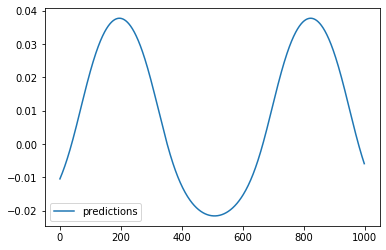

train step: 0, loss: 0.3919714
train step: 1000, loss: 0.0007607428
train step: 2000, loss: 0.0002649696
train step: 3000, loss: 4.444799e-05
train step: 4000, loss: 8.156785e-06
train step: 5000, loss: 5.0138706e-06
train step: 6000, loss: 4.8705137e-06
train step: 7000, loss: 5.2724954e-06
train step: 8000, loss: 3.7601337e-06
train step: 9000, loss: 2.9400003e-06
train step: 10000, loss: 4.290899e-06
train step: 11000, loss: 3.57701e-06
Evaluate model after training.
Root Mean Square Error is: 0.001939


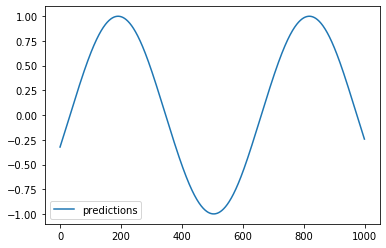

In [16]:
# 将训练数据以数据集的方式提供给计算图。
ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
X, y = ds.make_one_shot_iterator().get_next()

# 定义模型，得到预测结果、损失函数，和训练操作。
with tf.variable_scope("model",reuse=tf.AUTO_REUSE):
    _, loss, train_op = lstm_model(X, y, True)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 测试在训练之前的模型效果。
    print ("Evaluate model before training.")
    run_eval(sess, test_X, test_y)
    
    # 训练模型。
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 1000 == 0:
            print("train step: " + str(i) + ", loss: " + str(l))
    
    # 使用训练好的模型对测试数据进行预测。
    print ( "Evaluate model after training." )
    run_eval(sess, test_X, test_y)